In [1]:
# KGT mechanism generator
class reaction_obj():
    def __init__(self,degeneracy,reactants,products,loop=False,TYPE='bridge'):
        self.degeneracy = degeneracy
        self.reactants = reactants
        self.products = products
        self.loop = loop
        self.TYPE = TYPE

    def __str__(self):
        s = "+".join([str(x) for x in self.reactants])
        #s = s + ' ' + str(self.degeneracy) + '-> '
        s = s + ' -> '
        s = s + "+".join([str(x) for x in self.products])
        return s

class junction():
    def __init__(self,nA=0,nB=0,nX=0,nL=0,nD=0,nDX=0):
        self.nA = nA # number of free A groups
        self.nB = nB # number of free B groups
        self.nX = nX # number of bridges
        self.nL = nL # number of looping groups
        self.nD = nD # number of dangling groups
        self.nDX = nDX # number of direct x-link bonds

        if nA+nB+nX+nL+nD+nDX > 2:
            self.nJ = 1
        else:
            self.nJ = 0

    def __str__(self):
        #return "(A"+str(self.nA)+",B"+str(self.nB)+",X"+str(self.nX)+",L"+str(self.nL)+",D"+str(self.nD)+",DX"+str(self.nDX)+")="+str(self.nA+self.nB+self.nX+self.nL+self.nD+self.nDX)
        return "(A"+str(self.nA)+",B"+str(self.nB)+",X"+str(self.nX)+",L"+str(self.nL)+",D"+str(self.nD)+",DX"+str(self.nDX)+")"

    def getIdx(self):
        return (self.nA,self.nB,self.nX,self.nL,self.nD,self.nDX)

    def compare(self,mol2):
        if self.getIdx() == mol2.getIdx():
            return True
        else:
            return False

    def copy(self):
        copy = junction(self.nA,self.nB,self.nX,self.nL,self.nD,self.nDX)
        return copy

    def reactJ1AwJ2B(self,mol2):
        reactions = []
        # react A group on self with B group on mol2
        if self.nA>0 and mol2.nB>0:
            degeneracy = self.nA * mol2.nB
            products = []
            reactants = [self.copy(),mol2.copy()]

            if self.nJ + mol2.nJ == 1:
                if self.nJ == 1:
                    new_j = self.copy()
                    strand = mol2.copy()
                else:
                    new_j = mol2.copy()
                    strand = self.copy()

                if strand.nA == 0:
                    new_j.nA = new_j.nA-1
                    new_j.nB = new_j.nB+1
                else:
                    pass
                products.append(new_j)

            else:
                j1 = self.copy()
                j2 = mol2.copy()
                j1.nA = j1.nA -1
                j1.nX = j1.nX +1
                j2.nB = j2.nB -1
                j2.nX = j2.nX +1
                products.append(j1)
                products.append(j2)

            reactions.append(reaction_obj(degeneracy,reactants,products,loop=False,TYPE='bridge'))

        return reactions

    def reactJ1DwJ2D(self,mol2):
        reactions = []
        # reaction D(angling) group on self with D group on mol2
        if self.nD>0 and mol2.nD>0:
            degeneracy = self.nD * mol2.nD
            products = []
            reactants = [self.copy(),mol2.copy()]

            if self.nJ + mol2.nJ < 2:
                # reaction should always be between a pair of junctions
                return reactions

            elif self.nJ==1 and mol2.nJ == 1:
                j1 = self.copy()
                j2 = mol2.copy()
                j1.nD = j1.nD - 1
                j1.nDX = j1.nDX + 1
                j2.nD = j2.nD - 1
                j2.nDX = j2.nDX + 1
                products.append(j1)
                products.append(j2)
            
            else:
                return reactions

            reactions.append(reaction_obj(degeneracy,reactants,products,loop=False,TYPE='sideXlink'))
            #print(str(self)+'  '+str(mol2)) 
        

        return reactions

    def side_reactions(self):
        reactions = []
        reactants = [self.copy()]
        if self.nA>0:
            degeneracy = self.nA
            j = self.copy()
            j.nA = j.nA - 1
            j.nD = j.nD + 1
            products = [j]

            reactions.append(reaction_obj(degeneracy,reactants,products,loop=False,TYPE='side'))
        #print(str(self))
        return reactions
    
    def loop_reactions(self):
        reactions = []
        reactants = [self.copy()]
        if self.nA>0 and self.nB>0:
            degeneracy = self.nA*self.nB
            j = self.copy()
            j.nA = j.nA - 1
            j.nB = j.nB - 1
            j.nL = j.nL + 2
            products = [j]

            reactions.append(reaction_obj(degeneracy,reactants,products,loop=True,TYPE='loop'))

        return reactions

    def sideXlink_reactions(self,mol2):
        reactions = []
        # reaction D group on self with D group on mol2
        reactions = reactions + self.reactJ1DwJ2D(mol2)
        
        return reactions
        
    def reactions(self,mol2):
        # return the list of possible reaction outcomes between self and mol2
        # represented as a list of tuples (degeneracy,[product1,product2,...])

        reactions = []
        # react A group on self with B group on mol2
        reactions = reactions + self.reactJ1AwJ2B(mol2)
        # react B group on self with A group on mol2
        if self.getIdx() != mol2.getIdx():
            reactions = reactions + mol2.reactJ1AwJ2B(self)
            
        return reactions

In [2]:
# KGT main object definition
import numpy as np

class KGT():
    def __init__(self,nA=4,nB=2,rates={'bridge':1.0}):
        self.nA = nA
        self.nB = nB
        self.elements,self.all_reactions = self.getKGT(nA=self.nA,nB=self.nB)
        self.elements_idx = [j for j in self.elements.keys()]
        self.rates = rates
    
    def getKGT(self,nA,nB):
        LOOP = False
        SIDE = True
        SIDE_XLINK = False
        BRIDGE = True

        A4 = junction(nA=nA)
        B2 = junction(nB=nB)

        elements = dict()
        queue = [A4,B2]

        all_reactions= []

        while (not queue) == False:
            j = queue[0]
            queue = queue[1:]


            if j.getIdx() in elements:
                continue


            elements[j.getIdx()] = j.copy()
            # loop reactions
            if LOOP == True:
                reactions = j.loop_reactions()
                for rxn in reactions:
                        all_reactions.append(rxn)
                        for j_temp in rxn.products:
                            queue.append(j_temp)

            # unimolecular side reactions
            if SIDE == True:
                reactions = j.side_reactions()
                for rxn in reactions:
                        all_reactions.append(rxn)
                        for j_temp in rxn.products:
                            queue.append(j_temp)

            # side-crosslinking reactions
            if SIDE_XLINK == True:
                for j2 in list(elements.values()):
                    reactions = j.sideXlink_reactions(j2)

                    for rxn in reactions:
                        all_reactions.append(rxn)
                        for j_temp in rxn.products:
                            queue.append(j_temp)

            # intermolecular reactions
            if BRIDGE == True:
                for j2 in list(elements.values()):
                    reactions = j.reactions(j2)

                    for rxn in reactions:
                        all_reactions.append(rxn)
                        for j_temp in rxn.products:
                            queue.append(j_temp)

        return elements,all_reactions
    
    def element_list(self):
        return list(self.elements.values())
        
    def reaction_list(self):
        return self.all_reactions
    
    def get_element_idx(self,junctionIdx):
        return self.elements_idx.index(junctionIdx)
    
    def reaction_rate(self):
        
        def f(t,y):
            dim = len(self.elements)
            dydt = np.zeros((dim,))
        
            for r in self.all_reactions:
                if r.TYPE in self.rates:
                    k = self.rates[r.TYPE]
                else:
                    k = 0

                rate = k
                for j in r.reactants:
                    rate = rate * y[self.get_element_idx(j.getIdx())]
                
                rate = rate * r.degeneracy
                
                for j in r.reactants:
                    dydt[self.get_element_idx(j.getIdx())] -= rate

                for j in r.products:
                    dydt[self.get_element_idx(j.getIdx())] += rate
            
            return dydt
        
        return f
    
    def sumA(self,y):
        s = np.zeros((y.shape[1],))
        for j in self.elements.values():
            s += y[self.get_element_idx(j.getIdx()),:]*j.nA
        return s
    
    def sumB(self,y):
        s = np.zeros((y.shape[1],))
        for j in self.elements.values():
            s += y[self.get_element_idx(j.getIdx()),:]*j.nB
        return s
    
    def sumD(self,y):
        s = np.zeros((y.shape[1],))
        for j in self.elements.values():
            s += y[self.get_element_idx(j.getIdx()),:]*j.nD
        return s
            
    def sumX(self,y):
        s = np.zeros((y.shape[1],))
        for j in self.elements.values():
            s += y[self.get_element_idx(j.getIdx()),:]*j.nX
        return s
    
    def sumArms(self,y):
        s = np.zeros((y.shape[1],))
        s = self.sumA(y) + self.sumB(y) + self.sumX(y) + self.sumD(y) - y[self.get_element_idx((0,2,0,0,0,0)),:]*2
        return s
    
    def fi(self,y,i):
        s = np.zeros((y.shape[1],))
        for j in self.elements.values():
            if j.nX == i and j.nJ > 0:
                s += y[self.get_element_idx(j.getIdx()),:]
        return s
    
    def fia(self,y,i):
        s = np.zeros((y.shape[1],))
        for j in self.elements.values():
            if ( j.nX + j.nB == i ) and j.nJ > 0:
                s += y[self.get_element_idx(j.getIdx()),:]
        return s
    

In [3]:
# Create A4B2 KGT object and check if things looks correct
A4B2 = KGT(nA=4,nB=2)

print(len(A4B2.element_list()))
print(len(A4B2.reaction_list()))

for j in A4B2.elements:
    #print(j)
    pass
    
count = 0
for r in A4B2.reaction_list():
    print(r)
    count += 1
    if count > 10:
        break
#print(count)

36
440
(A4,B0,X0,L0,D0,DX0) -> (A3,B0,X0,L0,D1,DX0)
(A4,B0,X0,L0,D0,DX0)+(A0,B2,X0,L0,D0,DX0) -> (A3,B1,X0,L0,D0,DX0)
(A3,B0,X0,L0,D1,DX0) -> (A2,B0,X0,L0,D2,DX0)
(A3,B0,X0,L0,D1,DX0)+(A0,B2,X0,L0,D0,DX0) -> (A2,B1,X0,L0,D1,DX0)
(A3,B1,X0,L0,D0,DX0) -> (A2,B1,X0,L0,D1,DX0)
(A4,B0,X0,L0,D0,DX0)+(A3,B1,X0,L0,D0,DX0) -> (A3,B0,X1,L0,D0,DX0)+(A3,B0,X1,L0,D0,DX0)
(A3,B1,X0,L0,D0,DX0)+(A0,B2,X0,L0,D0,DX0) -> (A2,B2,X0,L0,D0,DX0)
(A3,B0,X0,L0,D1,DX0)+(A3,B1,X0,L0,D0,DX0) -> (A2,B0,X1,L0,D1,DX0)+(A3,B0,X1,L0,D0,DX0)
(A3,B1,X0,L0,D0,DX0)+(A3,B1,X0,L0,D0,DX0) -> (A2,B1,X1,L0,D0,DX0)+(A3,B0,X1,L0,D0,DX0)
(A2,B0,X0,L0,D2,DX0) -> (A1,B0,X0,L0,D3,DX0)
(A2,B0,X0,L0,D2,DX0)+(A0,B2,X0,L0,D0,DX0) -> (A1,B1,X0,L0,D2,DX0)


In [4]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt



def getP(r=1,Y=0.4):
    t_inc = 0.5
    dydt_tol = 1e-4
    PLOT = False
    
    yB2 = 1.0
    rates = {'bridge': 1.0, 'sideXlink': 1.0, 'side': Y*yB2, 'loop': 1.0}
    t_span = (0,t_inc)

    A4B2 = KGT(nA=4,nB=2,rates=rates)
    dim = len(A4B2.element_list())
    y0 = np.zeros((dim,))
    y0[1] = yB2
    y0[0] = y0[1]/2.0*r

    while True:
        sol = solve_ivp(A4B2.reaction_rate(),t_span,y0)
        dydt_end = max(sol.y[:,-1]-sol.y[:,-2])/(sol.t[-1]-sol.t[-2])
        if dydt_end < dydt_tol:
            break
        else:
            y0 = sol.y[:,-1]
    
    if PLOT:
        plt.plot(sol.t,A4B2.sumA(sol.y),label='A')
        plt.plot(sol.t,A4B2.sumD(sol.y),label='D')
        plt.plot(sol.t,A4B2.sumX(sol.y),label='X')
        plt.plot(sol.t,A4B2.sumX(sol.y)+A4B2.sumD(sol.y),label='D+X')
        plt.plot(sol.t,A4B2.sumArms(sol.y),label='all')
        fs = [A4B2.fi(sol.y,i) for i in range(5)]
        plt.plot(sol.t,sum(fs),label='junctions')
        plt.legend()


    Pa = 1 - (A4B2.sumA(sol.y)[-1] + A4B2.sumD(sol.y)[-1] )/(A4B2.sumArms(sol.y)[-1])
    Pb = 1 - (A4B2.sumB(sol.y)[-1])/(yB2*2)
    Pd = A4B2.sumD(sol.y)[-1]/(A4B2.sumArms(sol.y)[-1])
    
    fs = [A4B2.fi(sol.y,i)[-1] for i in range(5)]
    
    #print(A4B2.sumArms(sol.y)[-1])
    #print(sum(fs))
    #print(yB2/2.0*r)
    
    return Pa,Pb,Pd,fs

Pa,Pb,Pd,fs = getP(r=1.1,Y=0.4)
print(1-Pa)
print(Pd)

0.2828922215018096
0.28273646569893895


1.0 0.4
1.1 0.4
1.2 0.4
1.3 0.4
1.4 0.4
1.5 0.4
1.6 0.4
1.7000000000000002 0.4
1.8 0.4
1.9 0.4
2.0 0.4


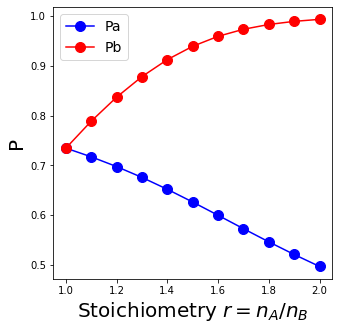

In [5]:
Y=0.4
rs = np.linspace(1,2,11)
Pas = []
Pbs = []

for r in rs:
    print(r,Y)
    Pa,Pb,Pd,fs = getP(r=r,Y=Y)
    Pas.append(Pa)
    Pbs.append(Pb)

fig = plt.figure()
ax = plt.gca()
plt.plot(rs,Pas,color='b',marker='o',markersize=10,linestyle='-',label='Pa')
plt.plot(rs,Pbs,color='r',marker='o',markersize=10,linestyle='-',label='Pb')
plt.xlabel('Stoichiometry $r=n_{A}/n_{B}$',fontsize=20)
plt.ylabel(r"P",fontsize=20)
ax.figure.set_size_inches(5, 5)
ax.legend(fontsize=14)
plt.show()

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.special
import scipy.optimize

#penalty = 0.0

#def F(pa,penalty=0,fmax=4):
#    f = list()
#    for i in range(fmax+1):
#        f.append(scipy.special.binom(fmax,i)*pa**i*(1-pa)**(fmax-i)*np.exp(-(i*penalty)))
#        #f.append(scipy.special.binom(fmax,i)*pa**i*(1-pa)**(fmax-i))
#    f = [x/sum(f) for x in f]
#    return f
#print(F(0.5,penalty=0.5))
#print(sum(F(0.5,penalty=0.5)))
    
def getR(Y,r,penalty=0,fmax=4,W=0,pa=None,pb=None,pd=None,f=None):
    if pa == None:
        pa,pb,pd,fs = getP(r=r,Y=Y)
    #pa = getPa(Y,r,penalty,fmax,W)
    #print(pa)
    #pb = Pb(pa,Y,r,penalty,fmax,W)
    #print(pb)
    #f = F(pa,penalty,fmax)
    ##Sum = sum([i*f[i] for i in range(len(f))])
    ##pi = [i*f[i]/Sum for i in range(len(f))]
    #print(pi)
    #fR = lambda R: (1-pb) + pb * sum([f[i]*R**2 for i in range(len(f))]) -R
    #fR = lambda R: (1-pa) + pa * ( (1-pb) + pb* sum([f[i]*R**(i-1) for i in range(1,len(f))] ) ) -R
    
    #fR = lambda R: (1-pa) + pa * ( (1-pb) + pb* sum([pi[i]*R**(i-1) for i in range(1,len(f))] ) ) -R # w/o additional x-links
    
    #fR = lambda R: (1-pa)*(1-W) + pa * ( (1-pb) + pb* sum([pi[i]*R**(i-1) for i in range(1,len(f))] ) ) -R # w/ additional x-links TODO correct term 
    #fR = lambda R: (1-pa)*(1-W + W*R**(fmax-1)) + pa*( (1-pb) + pb*R**(fmax-1))  - R

    fR = lambda R: (1-pa-pd) + pd*(1-W + W*R**(fmax-1)) + pa*( (1-pb) + pb*R**(fmax-1))  - R
    
    #fR = lambda R: (1-pa)*(1-W + W*sum([pi[i]*R**(i-1) for i in range(1,len(f))] )) + pa * ( (1-pb) + pb* sum([pi[i]*R**(i-1) for i in range(1,len(f))] ) ) -R # TODO, correct pi for prob. of encountering each type of junction
    
    return float(scipy.optimize.broyden1(fR,0.0))#,fR,pi,pa,pb
#getR(0.4,1.0)
    
#def getRb(Y,r,penalty=0,fmax=4,W=0):
#    pa = getPa(Y,r,penalty,fmax,W)
#    pb = Pb(pa,Y,r,penalty,fmax,W)
#    f = F(pa,penalty,fmax)
#    Sum = sum([i*f[i] for i in range(len(f))])
#    pi = [i*f[i]/Sum for i in range(len(f))]
#    fR = lambda R: (1-pb) + pb* sum( [  pi[i]*( (1-pa) + pa*R )**(i-1) for i in range(1,len(f))  ]  ) -R
#    return float(scipy.optimize.broyden1(fR,0.0))#,fR,pi,pa,pb
    
    
def getPgel(Y,r,penalty=0,fmax=4,W=0,pa=None,pb=None,pd=None,f=None):
    if pa == None:
        pa,pb,pd,f = getP(r=r,Y=Y)
    #pa = getPa(Y,r,penalty,fmax,W)
    #pb = Pb(pa,Y,r,penalty,fmax,W)
    #f = F(pa,penalty,fmax)
    Sum = sum([i*f[i] for i in range(len(f))])
    pi = [i*f[i]/Sum for i in range(len(f))]
    R = getR(Y,r,penalty,fmax,W,pa=pa,pb=pb,pd=pd,f=f)
    return pb*sum([pi[i]*(1-R**(i-1)) for i in range(2,fmax+1)])
    #return pb*sum([f[i]*(1-R**(i-1)) for i in range(2,fmax+1)])
                
def getPact(Y,r,penalty=0,fmax=4,W=0,pa=None,pb=None,pd=None,f=None):
    if pa == None:
        pa,pb,pd,f = getP(r=r,Y=Y)
    #pa = getPa(Y,r,penalty,fmax,W)
    #pb = Pb(pa,Y,r,penalty,fmax,W)
    #f = F(pa,penalty,fmax)
    R = getR(Y,r,penalty,fmax,W,pa=pa,pb=pb,pd=pd,f=f)
    Sum = sum([i*f[i] for i in range(len(f))])
    pi = [i*f[i]/Sum for i in range(len(f))]
    terms = list()
    for i in range(3,fmax+1):
        terms.append(sum([ scipy.special.binom(i-1,j)* R**(i-1-j)*(1-R)**(j) for j in range(2,i)])*pi[i])
        #terms.append(sum([ scipy.special.binom(i-1,j)* R**(i-1-j)*(1-R)**(j) for j in range(2,i)])*f[i])
    return pb*sum(terms)
        
def getPlin(Y,r,penalty=0,fmax=4,W=0,pa=None,pb=None,pd=None,f=None):
    if pa == None:
        pa,pb,pd,f = getP(r=r,Y=Y)
    #pa = getPa(Y,r,penalty,fmax,W)
    #pb = Pb(pa,Y,r,penalty,fmax,W)
    #f = F(pa,penalty,fmax)
    R = getR(Y,r,penalty,fmax,W,pa=pa,pb=pb,pd=pd,f=f)
    Sum = sum([i*f[i] for i in range(len(f))])
    pi = [i*f[i]/Sum for i in range(len(f))]
    return sum([pi[i]*(i-1)*(1-R)*R**(i-2) for i in range(2,fmax+1)]) * pb
    #return sum([f[i]*(i-1)*(1-R)*R**(i-2) for i in range(2,fmax+1)]) * pb
     
def getFgel(Y,r,penalty=0,fmax=4,W=0,pa=None,pb=None,pd=None,f=None):
    if pa == None:
        pa,pb,pd,f = getP(r=r,Y=Y)
    return getPgel(Y,r,penalty,fmax,W,pa=pa,pb=pb,pd=pd,f=f)**2

def getFact(Y,r,penalty=0,fmax=4,W=0,pa=None,pb=None,pd=None,f=None):
    if pa == None:
        pa,pb,pd,f = getP(r=r,Y=Y)
    return getPact(Y,r,penalty,fmax,W,pa=pa,pb=pb,pd=pd,f=f)**2

def getFlin(Y,r,penalty=0,fmax=4,W=0,pa=None,pb=None,pd=None,f=None):
    if pa == None:
        pa,pb,pd,f = getP(r=r,Y=Y)
    return getPlin(Y,r,penalty,fmax,W,pa=pa,pb=pb,pd=pd,f=f)**2

def getFeff(Y,r,penalty=0,fmax=4,W=0,pa=None,pb=None,pd=None,f=None):
    if pa == None:
        pa,pb,pd,f = getP(r=r,Y=Y)
    ret = getPgel(Y,r,penalty,fmax,W,pa=pa,pb=pb,pd=pd,f=f)**2 - getPlin(Y,r,penalty,fmax,W,pa=pa,pb=pb,pd=pd,f=f)**2 - getPlin(Y,r,penalty,fmax,W,pa=pa,pb=pb,pd=pd,f=f)*getPact(Y,r,penalty,fmax,W,pa=pa,pb=pb,pd=pd,f=f)
    #print(r,Y,W)
    return ret

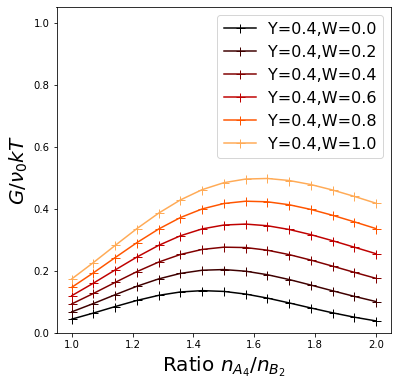

In [7]:
# MAIN RUN 1 !!!
# generate graph for different Y,W

#### CHANGE PARAM HERE ####
Y = 0.4
n = 6
Ws = np.linspace(0,1.0,n)
#### 

def plotF(Y=Y,W=0,fig_ax=None,linestyle='-'):
    r = np.linspace(1,2.0,15)
    #fgel=[getFgel(Y,x,W=W) for x in r]
    #fact=[getFact(Y,x,W=W) for x in r]
    feff=[getFeff(Y,x,W=W) for x in r]

    if fig_ax==None:
        fig = plt.figure()
        ax = plt.gca()
    else:
        fig,ax = fig_ax
    #plt.plot(r,fgel,color='#4b0557',marker='o',markersize=6,linestyle=linestyle,label='$f_{gel}$ (Y='+str(Y)+',W='+str(W)+')')
    plt.plot(r,feff,marker='+',markersize=9,linestyle=linestyle,label='Y='+str(Y)+',W='+str(round(W,1))+'')
    #plt.plot(r,fact,color='#0d5705',marker='x',markersize=8,linestyle='-',label='Elastically Active Strands')

    #plt.xlim((0,1.1*max(xdata)))
    plt.ylim((0,1.05))
    #plt.xticks(fontsize=13)
    #plt.yticks(fontsize=13)
    #plt.legend()
    plt.xlabel('Ratio $n_{A_4}/n_{B_2}$',fontsize=20)
    plt.ylabel(r"$G/\nu_0kT$",fontsize=20)
    ax.figure.set_size_inches(6, 6)
    ax.legend(fontsize=16)
    
    if fig_ax==None:
        plt.show()

fig = plt.figure()
ax = plt.gca()
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.gist_heat(np.linspace(0, 1, n+1))))

for W in Ws:
    plotF(Y=0.4,W=W,fig_ax=(fig,ax))
#plotF(Y=0.4,W=0.3,fig_ax=(fig,ax),linestyle=':')
plt.show()


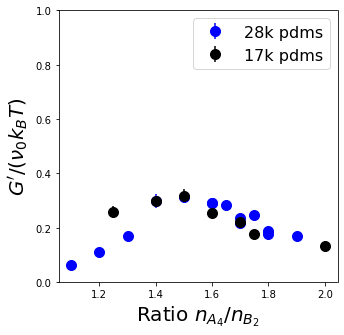

In [8]:
# Experimental results used !!!

Mw = 28000 # g/mol
M0 = 381 # g/mol
b = 1.3 # nm
Nbsq = Mw/M0*b**2 # nm^2
f=4

v28 = 8.271428571*1e-3 # mol/L
v17 = 13.46511628*1e-3 # mol/L

#cR3 = 2*v * Nbsq**1.5 * 6.02e23/1e24

#rexpold = np.array([1,1.25,1.5,1.75,2])
#Gold = np.array([7.33E+02,3.12E+03,4.96E+03,7.44E+03,4.18E+03])

rexp28 = np.array([1.1,1.2,1.3,1.4,1.5,1.6,1.65,1.7,1.75,1.8,1.9,1.6,1.7,1.8])
G28 = np.array([1338.172043,2297.290323,3513.010753,6186.021505,6501.935484,6028.642937,5840,4868.817204,5070.860215,3865.913978,3537.096774,6026.666667,4514.83871,3632.580645])
err28 = np.array([217.4320718,232.5914006,196.1463631,523.1425029,253.5633665,30.52606823,297.5237729,189.2672582,240.4137808,367.5434288,281.8086745,208.6127644,161.5562324,146.689802])

rexp17 = np.array([1.25,1.5,1.75,2,1.4,1.6,1.7])
G17 = np.array([8690.91954,10612.90323,5969.455074,4532.096774,9975.591398,8548.225806,7405.698925])
err17 = np.array([726.9888325,884.5591858,273.3886032,532.3478663,641.6392843,491.5532624,503.8026402])

T=300
R=8.314
#G_vRTold = Gold/R/T/v/1000
#G_vRT = G/R/T/v/1000

G28_vRT = G28/R/T/v28/1000
G17_vRT = G17/R/T/v17/1000

err28_vRT = err28/R/T/v28/1000
err17_vRT = err17/R/T/v17/1000

rexp = np.concatenate((rexp28,rexp17))
G_vRT = np.concatenate((G28_vRT,G17_vRT))
err_vRT = np.concatenate((err28_vRT,err17_vRT))

#print(v*2)
#print(Nbsq)
#print(cR3)

fig = plt.figure()
ax = plt.gca()


#plt.plot(rexpold,G_vRTold,color='r',marker='^',markersize=10,linestyle='')
plt.errorbar(rexp28,G28_vRT,yerr=err28_vRT,color='b',marker='o',markersize=10,linestyle='',label='28k pdms')
plt.errorbar(rexp17,G17_vRT,yerr=err17_vRT,color='k',marker='o',markersize=10,linestyle='',label='17k pdms')
#plt.errorbar(rexp,G,yerr=err,color='b',marker='o',markersize=10,linestyle='')
#plt.errorbar(rexprep,Grep,yerr=errrep,color='k',marker='^',markersize=10,linestyle='')

    
#plt.xlim((0,1.1*max(xdata)))
plt.ylim((0,1))
#plt.xticks(fontsize=13)
#plt.yticks(fontsize=13)
plt.legend(fontsize=16)
plt.xlabel('Ratio $n_{A_4}/n_{B_2}$',fontsize=20)
plt.ylabel(r"$G'/(\nu_0k_BT)$",fontsize=20)
ax.figure.set_size_inches(5, 5)
plt.show()

[1.2  1.3  1.4  1.5  1.6  1.65 1.7  1.75 1.8  1.9  1.6  1.7  1.8  1.25
 1.5  1.75 2.   1.4  1.6  1.7 ]
0.41086 0.3413
16.888667106628418 s
0.41086001 0.3413
17.702781438827515 s
0.41086 0.34130001
18.061955451965332 s
0.3 0.5671870917893816
23.908043384552002 s
0.30000001 0.5671870917893816
24.236718893051147 s
0.3 0.5671871017893817
24.423982858657837 s
0.39820170201059396 0.3670924059158425
18.86633563041687 s
0.39820171201059396 0.3670924059158425
19.044477701187134 s
0.39820170201059396 0.3670924159158425
18.35088801383972 s
0.3938516152128069 0.3641679378648546
18.121052742004395 s
0.3938516252128069 0.3641679378648546
18.38779044151306 s
0.3938516152128069 0.36416794786485457
18.494357585906982 s
0.3734693394701415 0.3367272787705639
19.22010850906372 s
0.3734693494701415 0.3367272787705639
19.41581678390503 s
0.3734693394701415 0.3367272887705639
19.311033964157104 s
0.3649721450397346 0.3160435847899216
19.780587196350098 s
0.36497215503973457 0.3160435847899216
19.785009384155

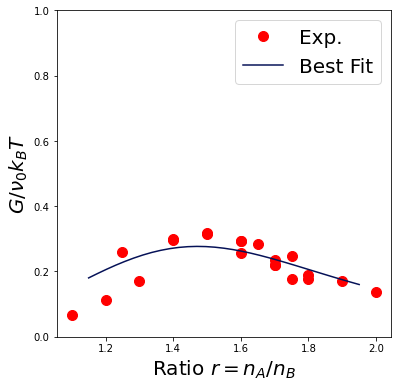

In [9]:
### RUN PART 2 - BEST FIT for model 

import scipy.optimize
import time

p = 0.0
start = 1
r = rexp[start:]
y = G_vRT[start:]
print(r)

def ObjFcn(params):
    Y = params[0]
    W = params[1]
    print(str(Y)+' '+str(W))
    start = time.time()
    runique = np.unique(r)
    pred = dict()
    for ri in list(runique):
        pred[ri] = getFeff(Y,ri,W=W,penalty=p)
    mse = sum([(pred[r[i]]-y[i])**2 for i in range(len(r))])   
    #mse = sum([(getFeff(Y,r[i],W=W,penalty=p)-y[i])**2 for i in range(len(r))])
    end = time.time()
    print(str(end-start)+' s')
    return mse
    #return sum([(getFgel(Y,r[i],W=W)-y[i])**2 for i in range(len(r))])
    
#sol = scipy.optimize.minimize_scalar(ObjFcn)
#sol = scipy.optimize.minimize(ObjFcn,[0.5,0.5])
sol = scipy.optimize.minimize(ObjFcn,[0.41086,0.3413],bounds=[(0.3,0.6),(0.3,0.6)])
Yopt = sol.x[0]
Wopt = sol.x[1]
#Popt = sol.x[2]
print('Y = '+str(Yopt))
print('W = '+str(Wopt))
##print('p = '+str(p))
#print('Pa = '+str(getPa(Yopt,W=Wopt)))
#print('Ra = '+str(getR(Yopt,W=Wopt)))

r = np.linspace(1.15,1.95,31)

fig = plt.figure()
ax = plt.gca()

plt.plot(rexp,G_vRT,color='r',marker='o',markersize=10,linestyle='',label='Exp.')
feff=[getFeff(Yopt,x,W=Wopt) for x in r]
plt.plot(r,feff,color='#051157',marker='',markersize=6,linestyle='-',label='Best Fit')

#plt.xlim((0,1.1*max(xdata)))
plt.ylim((0,1))
#plt.xticks(fontsize=13)
#plt.yticks(fontsize=13)
#plt.legend()
plt.xlabel('Ratio $r=n_{A}/n_{B}$',fontsize=20)
#plt.ylabel(r"Fraction",fontsize=20)
plt.ylabel(r"$G/\nu_0k_BT$",fontsize=20)
ax.figure.set_size_inches(6, 6)
ax.legend(fontsize=20)
plt.show()

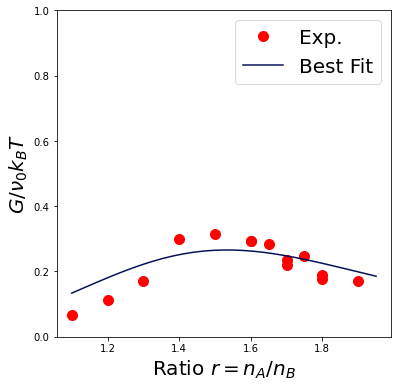

In [21]:
### PREVIOUSLY FITTED RESULTS and plots

Yopt = 0.4108363225354512
Wopt = 0.3922070652139855

r = np.linspace(1.1,1.95,31)

fig = plt.figure()
ax = plt.gca()

plt.plot(rexp28,G28_vRT,color='r',marker='o',markersize=10,linestyle='',label='Exp.')
feff=[getFeff(Yopt,x,W=Wopt) for x in r]
plt.plot(r,feff,color='#051157',marker='',markersize=6,linestyle='-',label='Best Fit')

#plt.xlim((0,1.1*max(xdata)))
plt.ylim((0,1))
#plt.xticks(fontsize=13)
#plt.yticks(fontsize=13)
#plt.legend()
plt.xlabel('Ratio $r=n_{A}/n_{B}$',fontsize=20)
#plt.ylabel(r"Fraction",fontsize=20)
plt.ylabel(r"$G/\nu_0k_BT$",fontsize=20)
ax.figure.set_size_inches(6, 6)
ax.legend(fontsize=20)
plt.show()

13.784361401907972


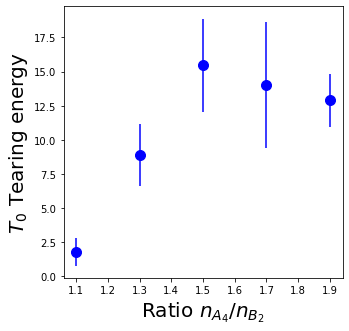

In [13]:
# Experimental results

Mw = 28000 # g/mol
M0 = 381 # g/mol
b = 1.3 # nm
Nbsq = Mw/M0*b**2 # nm^2
f=4

v = 8.271428571*1e-3 # mol/L

cR3 = 2*v * Nbsq**1.5 * 6.02e23/1e24


rexpT = np.array([1.1,1.3,1.5,1.7,1.9])
T0 = np.array([1.787284904,8.907833826,15.47329478,14.02183161,12.88815335])
err = np.array([1.0110987,2.2677672,3.395988382,4.581471078,1.968163481])


T=300
R=8.314
#G_vRTold = Gold/R/T/v/1000
#G_vRT = G/R/T/v/1000

#print(v*2)
#print(Nbsq)
print(cR3)

fig = plt.figure()
ax = plt.gca()


#plt.plot(rexpold,G_vRTold,color='r',marker='^',markersize=10,linestyle='')
#plt.plot(rexp,G_vRT,color='b',marker='o',markersize=10,linestyle='')
plt.errorbar(rexpT,T0,yerr=err,color='b',marker='o',markersize=10,linestyle='')
#plt.errorbar(rexprep,Grep,yerr=errrep,color='k',marker='^',markersize=10,linestyle='')

    
#plt.xlim((0,1.1*max(xdata)))
#plt.ylim((0,(f-2)/f))
#plt.xticks(fontsize=13)
#plt.yticks(fontsize=13)
#plt.legend()
plt.xlabel('Ratio $n_{A_4}/n_{B_2}$',fontsize=20)
plt.ylabel(r"$T_0$ Tearing energy",fontsize=20)
ax.figure.set_size_inches(5, 5)
plt.show()

In [14]:
Y = 0.3650552273242109
W = 0.30861035001561743

r = 1.5
pa,pb,pd,f = getP(r=r,Y=Y)

Plin = getPlin(Y,r,penalty=0,fmax=4,W=W,pa=pa,pb=pb,pd=pd,f=f)
Pact = getPact(Y,r,penalty=0,fmax=4,W=W,pa=pa,pb=pb,pd=pd,f=f)

print(Pact)
print(Plin)
print((Pact+Plin)**2)

frac = [(Pact/(Pact+Plin))*(Plin/(Pact+Plin))**i for i in range(20)]
veff = sum(frac)
veff2 = getFeff(Y,r,W=W)
#frac = frac/sum(frac)
print(frac)
print(veff)
print(veff2)

0.360599800472862
0.4034348655361172
0.5837489708634523
[0.47196785239666617, 0.2492141987007449, 0.1315931085531983, 0.06948539171914393, 0.03669052061651848, 0.01937377439782465, 0.010229975702465836, 0.005401756040102959, 0.002852300842684846, 0.0015061065395736777, 0.0007952726706105147, 0.00041992953619270876, 0.0002217362948379079, 0.00011708389196486654, 6.18240589239652e-05, 3.26450906071764e-05, 1.7237657302012777e-05, 9.102037204832097e-06, 4.806168252832937e-06, 2.537811344286339e-06]
0.9999971607261648
0.27551074811718784


1.1
[0.41749057324796235, 0.2431921944970501, 0.14166174580704666, 0.0825193023427556, 0.04806827150365664, 0.02800022127855633, 0.016310392845902053, 0.009500957586766938, 0.005534397357463031, 0.0032238386321137816]
1.3
[0.4753933985552016, 0.2493945151653369, 0.13083400901986067, 0.06863638482530722, 0.03600710057866176, 0.018889562662452786, 0.009909589271127915, 0.005198635949240254, 0.002727238737479684, 0.0014307274453978203]
1.5
[0.47196785239666617, 0.2492141987007449, 0.1315931085531983, 0.06948539171914393, 0.03669052061651848, 0.01937377439782465, 0.010229975702465836, 0.005401756040102959, 0.002852300842684846, 0.0015061065395736777]
1.7
[0.42438391351301796, 0.24428220746439325, 0.14061276825905505, 0.08093897137537821, 0.04658977394737707, 0.026817823349902337, 0.015436770524769992, 0.008885653437465698, 0.005114725057553605, 0.0029441180210859103]
1.9
[0.362989863624886, 0.23122822253047265, 0.14729472156791157, 0.0938282306733098, 0.059769534017040715, 0.03807379901527

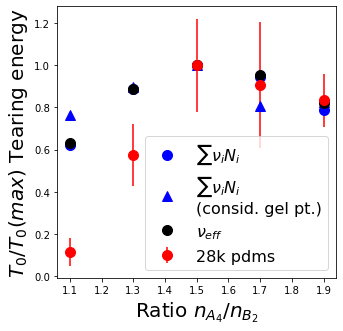

In [22]:
Y = 0.3650552273242109
W = 0.30861035001561743

rs = rexpT

Tgels = list()
Ts_gelpt = list()
Ts = list()

for r in rs:
    print(r)
    vgel = getFgel(Y,r,W=W)
    
    veff = getFeff(Y,r,W=W)
    pa,pb,pd,f = getP(r=r,Y=Y)
    Plin = getPlin(Y,r,penalty=0,fmax=4,W=W,pa=pa,pb=pb,pd=pd,f=f)
    Pact = getPact(Y,r,penalty=0,fmax=4,W=W,pa=pa,pb=pb,pd=pd,f=f)
    frac = [(Pact/(Pact+Plin))*(Plin/(Pact+Plin))**i for i in range(10)]
    T_gelpt = 0
    x = 0
    for i in range(len(frac)):
        T_gelpt = T_gelpt + veff*frac[i]*(i+1)
        x = x + frac[i]
        if 1-x < 1/(4-1):
            break
    T = sum([veff*frac[i]*(i+1) for i in range(len(frac))])
    #T1 = sum([veff*frac[i]*(i+1)**0 for i in range(len(frac))])
    print(frac)
    #print((T,T1,T1/T))
    Tgels.append(vgel)
    Ts.append(T)
    Ts_gelpt.append(T_gelpt)
    
fig = plt.figure()
ax = plt.gca()

plt.errorbar(rs,Ts/max(Ts),color='b',marker='o',markersize=10,linestyle='',label=r"$\sum \nu_i N_i$")
plt.errorbar(rs,Ts_gelpt/max(Ts_gelpt),color='b',marker='^',markersize=10,linestyle='',label=r"$\sum \nu_i N_i$"+'\n'+"(consid. gel pt.)")
plt.errorbar(rs,Tgels/max(Tgels),color='k',marker='o',markersize=10,linestyle='',label=r"$\nu_{eff}$")
plt.errorbar(rexpT,T0/max(T0),yerr=err/max(T0),color='r',marker='o',markersize=10,linestyle='',label='28k pdms')
    
#plt.xlim((0,1.1*max(xdata)))
#plt.ylim((0,(f-2)/f))
#plt.xticks(fontsize=13)
#plt.yticks(fontsize=13)
plt.legend(fontsize=16,loc='lower right')
plt.xlabel('Ratio $n_{A_4}/n_{B_2}$',fontsize=20)
plt.ylabel(r"$T_0/T_0(max)$ Tearing energy",fontsize=20)
ax.figure.set_size_inches(5, 5)
plt.show()

1.1
1.1400000000000001
1.1800000000000002
1.22
1.26
1.3
1.34
1.3800000000000001
1.42
1.46
1.5
1.54
1.58
1.62
1.6600000000000001
1.7
1.74
1.78
1.8199999999999998
1.8599999999999999
1.9


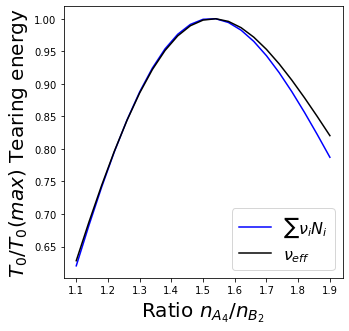

In [31]:
Y = 0.3650552273242109
W = 0.30861035001561743

rs = np.linspace(1.1,1.9,21)

Tgels = list()
Ts = list()

for r in rs:
    print(r)
    vgel = getFgel(Y,r,W=W)
    
    veff = getFeff(Y,r,W=W)
    pa,pb,pd,f = getP(r=r,Y=Y)
    Plin = getPlin(Y,r,penalty=0,fmax=4,W=W,pa=pa,pb=pb,pd=pd,f=f)
    Pact = getPact(Y,r,penalty=0,fmax=4,W=W,pa=pa,pb=pb,pd=pd,f=f)
    frac = [(Pact/(Pact+Plin))*(Plin/(Pact+Plin))**i for i in range(10)]
    T = sum([veff*frac[i]*(i+1) for i in range(len(frac))])
    T1 = sum([veff*frac[i]*(i+1)**0 for i in range(len(frac))])
    #print(frac)
    #print((T,T1,T1/T))
    Tgels.append(vgel)
    Ts.append(T)
    
fig = plt.figure()
ax = plt.gca()

plt.errorbar(rs,Ts/max(Ts),color='b',marker='',markersize=10,linestyle='-',label=r"$\sum \nu_i N_i$")
plt.errorbar(rs,Tgels/max(Tgels),color='k',marker='',markersize=10,linestyle='-',label=r"$\nu_{eff}$")
#plt.errorbar(rexp,T0/max(T0),yerr=err/max(T0),color='r',marker='o',markersize=10,linestyle='',label='28k pdms')
    
#plt.xlim((0,1.1*max(xdata)))
#plt.ylim((0,(f-2)/f))
#plt.xticks(fontsize=13)
#plt.yticks(fontsize=13)
plt.legend(fontsize=16,loc='lower right')
plt.xlabel('Ratio $n_{A_4}/n_{B_2}$',fontsize=20)
plt.ylabel(r"$T_0/T_0(max)$ Tearing energy",fontsize=20)
ax.figure.set_size_inches(5, 5)
plt.show()

26.122215142460156


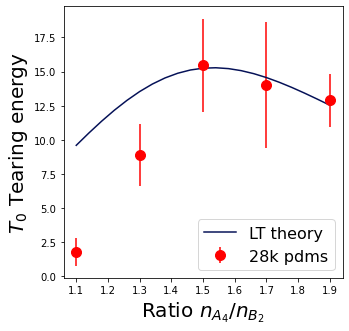

In [32]:
### RUN PART 3 - fit for tearing energy

from scipy import interpolate
import scipy.optimize

f = scipy.interpolate.interp1d(rs,Tgels)
start =2 
r = rexpT[start:]
y = T0[start:]

def ObjFcn(params):
    se = [(f(r[i])*params[0]-y[i])**2 for i in range(len(r))]
    mse = sum(se)   
    #mse = sum([(getFeff(Y,r[i],W=W,penalty=p)-y[i])**2 for i in range(len(r))])
    return mse
    
sol = scipy.optimize.minimize(ObjFcn,[15],bounds=[(0,100)])
print(sol.x[0])

fig = plt.figure()
ax = plt.gca()

plt.errorbar(rs,np.array(Tgels)*sol.x[0],color='#051157',marker='',markersize=10,linestyle='-',label='LT theory')
plt.errorbar(rexpT,T0,yerr=err,color='r',marker='o',markersize=10,linestyle='',label='28k pdms')
    
#plt.xlim((0,1.1*max(xdata)))
#plt.ylim((0,(f-2)/f))
#plt.xticks(fontsize=13)
#plt.yticks(fontsize=13)
plt.legend(fontsize=16,loc='lower right')
plt.xlabel('Ratio $n_{A_4}/n_{B_2}$',fontsize=20)
plt.ylabel(r"$T_0$ Tearing energy",fontsize=20)
ax.figure.set_size_inches(5, 5)
plt.show()

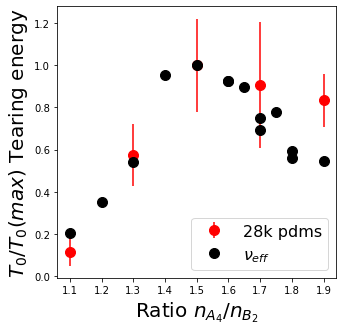

In [25]:
#rexp28 = np.array([1.1,1.2,1.3,1.4,1.5,1.6,1.65,1.7,1.75,1.8,1.9,1.6,1.7,1.8])
#G28_vRT

G28f = scipy.interpolate.interp1d(rexp28,G28_vRT)

rs = rexpT

Tgels = list()
for r in rs:
    vgel = G28f(r)
    Tgels.append(vgel)

    
fig = plt.figure()
ax = plt.gca()

plt.errorbar(rexpT,T0/max(T0),yerr=err/max(T0),color='r',marker='o',markersize=10,linestyle='',label='28k pdms')
#plt.errorbar(rs,Tgels/max(Tgels),color='k',marker='o',markersize=10,linestyle='',label=r"$\nu_{eff}$")
plt.errorbar(rexp28,G28_vRT/G28_vRT[4],color='k',marker='o',markersize=10,linestyle='',label=r"$\nu_{eff}$")

    
#plt.xlim((0,1.1*max(xdata)))
#plt.ylim((0,(f-2)/f))
#plt.xticks(fontsize=13)
#plt.yticks(fontsize=13)
plt.legend(fontsize=16,loc='lower right')
plt.xlabel('Ratio $n_{A_4}/n_{B_2}$',fontsize=20)
plt.ylabel(r"$T_0/T_0(max)$ Tearing energy",fontsize=20)
ax.figure.set_size_inches(5, 5)
plt.show()